In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import numpy as np
import seaborn as sns   
from scipy.stats import chi2_contingency
import csv

# Data Analysis
Analyze the processed data from CLEAN-Contact, CLEAN, and BioCyc. See /case-study/analysis/notebooks/data_processing.ipynb for details on how the data was processed.

CLEAN-Contact
* both .csvs with CLEAN-Contact results have 1939 rows and UniProt Ids
    * cc_maxsep_results_full.csv
    * cc_pvalue_results_full.csv
* this notebook analyzes the maxsep inference method results, which includes confidence scores

CLEAN 
* results .csv has 1942 rows and UniProt ids
    * clean_combined_results_full.csv
* this notebook analyzes the maxsep inference method results, which includes confidence scores, since the CLEAN results for the pvalue inference method doesn't have confidence scores

BioCyc 
* Prochlorococcus marinus subsp. pastoris str. CCMP1986, also known as MED4, data pulled from BioCyc
* this dataset has 728 rows. Of those, 684 have both a Uniprot id and an EC number
    * biocyc_updated.csv

The CLEAN-Contact results had 1939 ids not 1942 like the CLEAN results because we didn't have the protein structures for 3 of the proteins.

In [2]:
def list_of_unique_ecs(df, colname):
    # using a set guarantees elements in the list will be unique
    # EC numbers containing 'n' are also seen as unique
    unique_ec_values = set()

    for entry in df[colname]:
        # skip the NaN values
        if pd.isna(entry):
            continue
        ec_list = entry.split(', ')
        # update the set with the split values
        unique_ec_values.update(ec_list)

    # convert the set back to a sorted list
    unique_ec_values_list = sorted(unique_ec_values)
    return unique_ec_values_list

def calculate_subsets(list1, list2, list3):
    # inputs are lists, outputs are sets
    set1 = set(list1)
    set2 = set(list2)
    set3 = set(list3)
    # calculate subsets of the EC numbers found in each dataset
    only_set1 = set1 - (set2 | set3)
    only_set2 = set2 - (set1 | set3)
    only_set3 = set3 - (set1 | set2)

    set1_and_set2 = (set1 & set2) - set3
    set1_and_set3 = (set1 & set3) - set2
    set2_and_set3 = (set2 & set3) - set1

    all_three = set1 & set2 & set3
    return only_set1, only_set2, only_set3, set1_and_set2, set1_and_set3, set2_and_set3, all_three

def separate_sets_by_number_of_ec_digits(ec_set):
    # input one of the ec number sets
    # output dict containing subsets, with different lengths of digits in the ec numbers
    length_counts = {}
    length_subsets = {}

    # categorize, count, and subset
    for ec in ec_set:
        # split by '.' after removing the 'EC:'
        parts = ec[3:].split('.')
        length = len(parts)

        # initialize dictionary entries if not already present
        if length not in length_counts:
            length_counts[length] = 0
            length_subsets[length] = set()

        # increment count
        length_counts[length] += 1
        # add to appropriate subset
        length_subsets[length].add(ec)
    return length_subsets

def subset_ec_by_first_digit(ec_set):
    starting_number_subsets = {}

    # Categorize based on the first number
    for ec in ec_set:
        # Extract the first number after 'EC:'
        first_number = ec.split(':')[1].split('.')[0]

        # Initialize the dictionary entry if not already present
        if first_number not in starting_number_subsets:
            starting_number_subsets[first_number] = set()

        # Add the EC number to the appropriate subset
        starting_number_subsets[first_number].add(ec)
    return starting_number_subsets

def visualize_first_digits_distribution(ec_set, plot_title, use_percentage=False):
    # visualize one set
    class_names = {
        '1': 'Oxidoreductases',
        '2': 'Transferases',
        '3': 'Hydrolases',
        '4': 'Lyases',
        '5': 'Isomerases',
        '6': 'Ligases',
        '7': 'Translocases'}

    starting_number_subsets = subset_ec_by_first_digit(ec_set)
    sorted_keys = sorted(starting_number_subsets.keys(), key=int)
    
    # for calculating percentages
    total_ec_numbers = len(ec_set)
    percentages = [len(starting_number_subsets[key]) / total_ec_numbers * 100 for key in sorted_keys]
    
    # visualization
    labels = [f'{key}: {class_names.get(key, "Unknown Class")}' for key in sorted_keys]
    counts = [len(starting_number_subsets[key]) for key in sorted_keys]

    plt.figure(figsize=(10, 6))
    if use_percentage == False:
        plt.bar(labels, counts)
        plt.xlabel('Top Level EC number')
        plt.ylabel('Count')
        plt.title(plot_title)
        plt.xticks(fontsize=9) 
        plt.tight_layout() 
        plt.show()
    else:
        plt.bar(labels, percentages)
        plt.xlabel('Top Level EC number')
        plt.ylabel('Percentage (%)')
        plt.title(plot_title)
        plt.xticks(fontsize=9)  
        plt.tight_layout() 
        plt.show()   
        
def get_counts(ec_set):
    starting_number_subsets = subset_ec_by_first_digit(ec_set)
    sorted_keys = sorted(starting_number_subsets.keys(), key=int)
    counts = [len(starting_number_subsets[key]) for key in sorted_keys]
    return sorted_keys, counts

def visualize_combined_distributions(ec_sets, plot_title, dataset_labels, use_percent=False):
    # visualze three sets in one visual
    class_names = {
        '1': 'Oxidoreductases',
        '2': 'Transferases',
        '3': 'Hydrolases',
        '4': 'Lyases',
        '5': 'Isomerases',
        '6': 'Ligases',
        '7': 'Translocases'}

    all_keys = set()
    counts_per_set = []
    percentages_per_set = []

    # get counts for all sets and collect all unique keys
    for ec_set in ec_sets:
        keys, counts = get_counts(ec_set)
        total = sum(counts)
        percentages = [(count / total * 100) for count in counts]
        all_keys.update(keys)
        counts_per_set.append(dict(zip(keys, counts)))
        percentages_per_set.append(dict(zip(keys, percentages)))

    combined_keys = sorted(all_keys, key=int)

    combined_counts = []
    for counts_dict in counts_per_set:
        combined_counts.append([counts_dict.get(key, 0) for key in combined_keys])
    
    combined_percentages = []
    for percentages_dict in percentages_per_set:
        combined_percentages.append([percentages_dict.get(key, 0.0) for key in combined_keys])

    # bar width
    num_datasets = len(ec_sets)
    bar_width = 0.8 / num_datasets  # adjust width based on number of datasets

    x = np.arange(len(combined_keys))
    fig, ax = plt.subplots(figsize=(12, 7))
    sns_colors = sns.color_palette("colorblind", num_datasets)
    
    if use_percent == False:
        for i, counts in enumerate(combined_counts):
            ax.bar(x + i * bar_width - bar_width*(num_datasets-1)/2, counts, bar_width, 
                   label=dataset_labels[i], color=sns_colors[i])

        # labels for top-level EC numbers
        labels = [f'{key}: {class_names.get(key, "Unknown Class")}' for key in combined_keys]
        ax.set_xlabel('Top Level EC number')
        ax.set_ylabel('Count')
        ax.set_title(plot_title)
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()
        plt.xticks(fontsize=11) 
        plt.tight_layout()
        plt.show()
    else:
        for i, percentages in enumerate(combined_percentages):
            ax.bar(x + i * bar_width - bar_width*(num_datasets-1)/2, percentages, bar_width, 
                   label=custom_labels[i], color=sns_colors[i])

        labels = [f'{key}: {class_names.get(key, "Unknown Class")}' for key in combined_keys]
        ax.set_xlabel('Top Level EC number')
        ax.set_ylabel('Percentage (%)')
        ax.set_title(plot_title)
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()
        plt.xticks(fontsize=11) 
        plt.tight_layout()
        plt.show()

### Look at all unique EC numbers in each of the 3 datasets, by top level EC number



In [3]:
# CLEAN-Contact dataset
cc_maxsep = pd.read_csv('cc_maxsep_results_full.csv')
print("row and col numbers for CLEAN-Contact dataframe:", cc_maxsep.shape)
print("Number of non-NaN values in the 'CC maxsep EC' column:", cc_maxsep['CC maxsep EC'].count())

# list of the unique EC numbers from CLEAN-Contact's maxsep inference method, for all 1939 UniProt ids in that dataset
cc_maxsep_ec_list = list_of_unique_ecs(cc_maxsep, 'CC maxsep EC')
print("unique number of ec numbers in the CLEAN-Contact dataset:", len(cc_maxsep_ec_list)) 

row and col numbers for CLEAN-Contact dataframe: (1939, 7)
Number of non-NaN values in the 'CC maxsep EC' column: 1939
unique number of ec numbers in the CLEAN-Contact dataset: 1054


In [4]:
cc_maxsep

,UniProt,Annotation,Sequence,CC maxsep EC,CC maxsep conf,CC maxsep conf SD,CC maxsep cluster dist
0,Q7TU21,Aspartate-semialdehyde dehydrogenase OS=Prochl...,MRNSPFLPNRPLKVAVLGSSGAVGSELLKILEERDFPISELVLLSS...,EC:1.2.1.11,0.9863,0.0041,4.3332
1,Q7UZH7,CTP synthase OS=Prochlorococcus marinus subsp....,MSKFVFVTGGVVSSIGKGIVAASLGRLLKSRGYSVSILKLDPYLNV...,EC:6.3.4.2,0.9961,0.0017,2.8527
2,Q7UZR6,Bifunctional pantoate ligase/cytidylate kinase...,MNKIIIRKTEDLKEWRRNLKCDINFIPTMGNLHDGHQKLISTAQSS...,EC:6.3.2.1,0.8120,0.0551,5.8351
3,Q7V010,Probable dual-specificity RNA methyltransferas...,MKNLLGCSVKDLEKIALNYGQAAFRGRQIYNWLYNYKNRSKSIDEI...,EC:2.1.1.192,0.9923,0.0025,3.8433
4,Q7V0C4,Circadian clock oscillator protein KaiC OS=Pro...,MKDKKISKSIKMQVQKIPTGIEGFDDVCRGGLPAARSTLVSGTSGT...,EC:2.7.11.1,0.0911,0.0452,7.2259
...,...,...,...,...,...,...,...
1934,Q7V3R0,Antitermination protein NusB OS=Prochlorococcu...,MMHNRSLSRELSLLSLGLIKDTADLELNKIQIDEIFESALDSLINH...,EC:4.2.3.187,0.0014,0.0012,8.4480
1935,Q7V3R1,Transporter OS=Prochlorococcus marinus subsp. ...,MVESTQSQDSNLGTRLQQDLKNDLIAGLLVVIPLATTIWLSSIVSK...,EC:2.7.1.66,0.0014,0.0012,8.4444
1936,Q7V3R2,4Fe-4S ferredoxin-type domain-containing prote...,MRNMIQNKKEFSEKLKKRAIFEGFAVSGIASIPGSSRVKLRTQALE...,EC:1.17.99.6,0.9914,0.0028,3.9525
1937,Q7V3R3,Uncharacterized protein OS=Prochlorococcus mar...,MKKSLLKILFFSIISSHVFIAESLKALIPYYYLPETKSLQKQGLSI...,EC:3.5.2.6,0.0787,0.0403,7.2768


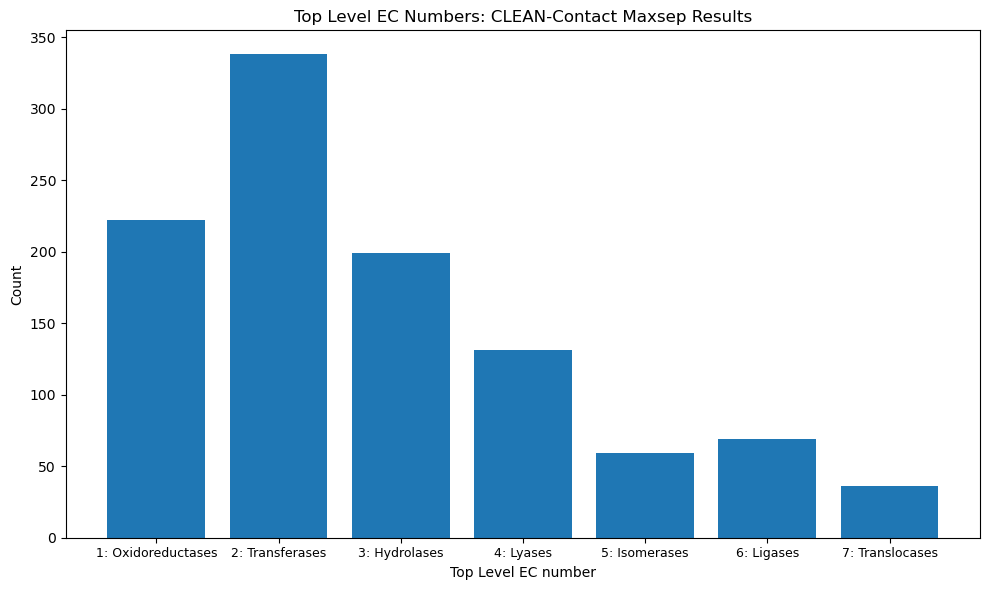

In [5]:
# visualize the unique EC numbers in a dataset by their top level number, using actual counts
visualize_first_digits_distribution(set(cc_maxsep_ec_list), 'Top Level EC Numbers: CLEAN-Contact Maxsep Results')
# include 'True' param to view using percentage of the input set not counts
#visualize_first_digits_distribution(set(cc_maxsep_ec_list), 'Top Level EC Numbers: CLEAN-Contact Maxsep Results', True)

In [6]:
# CLEAN dataset
clean_results = pd.read_csv('clean_combined_results_full.csv')
print("row and col numbers for CLEAN dataframe:", clean_results.shape)
print("Number of non-NaN values in the 'Clean maxsep EC' column:", clean_results['Clean maxsep EC'].count())

# list of the unique EC numbers from CLEAN's maxsep inference method, for all 1942 UniProt ids in that dataset
clean_maxsep_ec_list = list_of_unique_ecs(clean_results, 'Clean maxsep EC')
print("unique number of ec numbers in the CLEAN dataset:", len(clean_maxsep_ec_list)) 

row and col numbers for CLEAN dataframe: (1942, 7)
Number of non-NaN values in the 'Clean maxsep EC' column: 1942
unique number of ec numbers in the CLEAN dataset: 1053


In [7]:
clean_results

,UniProt,Annotation,Sequence,Clean maxsep EC,Clean maxsep conf,Clean pvalue EC,Clean pvalue cluster dist
0,Q7TU21,Aspartate-semialdehyde dehydrogenase OS=Prochl...,MRNSPFLPNRPLKVAVLGSSGAVGSELLKILEERDFPISELVLLSS...,EC:1.2.1.11,0.9935,EC:1.2.1.11,3.7585
1,Q7UZH7,CTP synthase OS=Prochlorococcus marinus subsp....,MSKFVFVTGGVVSSIGKGIVAASLGRLLKSRGYSVSILKLDPYLNV...,EC:6.3.4.2,0.9976,EC:6.3.4.2,2.9574
2,Q7UZR6,Bifunctional pantoate ligase/cytidylate kinase...,MNKIIIRKTEDLKEWRRNLKCDINFIPTMGNLHDGHQKLISTAQSS...,EC:2.7.4.25,0.2534,EC:2.7.4.25,6.4352
3,Q7V010,Probable dual-specificity RNA methyltransferas...,MKNLLGCSVKDLEKIALNYGQAAFRGRQIYNWLYNYKNRSKSIDEI...,EC:2.1.1.192,0.9917,"EC:2.1.1.192, EC:2.1.1.224","3.9242, 4.9630"
4,Q7V0C4,Circadian clock oscillator protein KaiC OS=Pro...,MKDKKISKSIKMQVQKIPTGIEGFDDVCRGGLPAARSTLVSGTSGT...,EC:2.7.11.1,0.0451,EC:2.7.11.1,7.0824
...,...,...,...,...,...,...,...
1937,Q7V3R0,Antitermination protein NusB OS=Prochlorococcu...,MMHNRSLSRELSLLSLGLIKDTADLELNKIQIDEIFESALDSLINH...,EC:2.5.1.17,0.0002,EC:2.5.1.17,8.6199
1938,Q7V3R1,Transporter OS=Prochlorococcus marinus subsp. ...,MVESTQSQDSNLGTRLQQDLKNDLIAGLLVVIPLATTIWLSSIVSK...,EC:1.1.5.2,0.0001,EC:1.1.5.2,8.6942
1939,Q7V3R2,4Fe-4S ferredoxin-type domain-containing prote...,MRNMIQNKKEFSEKLKKRAIFEGFAVSGIASIPGSSRVKLRTQALE...,EC:1.17.99.6,0.9886,EC:1.17.99.6,4.1148
1940,Q7V3R3,Uncharacterized protein OS=Prochlorococcus mar...,MKKSLLKILFFSIISSHVFIAESLKALIPYYYLPETKSLQKQGLSI...,EC:5.2.1.8,0.0077,EC:5.2.1.8,7.6222


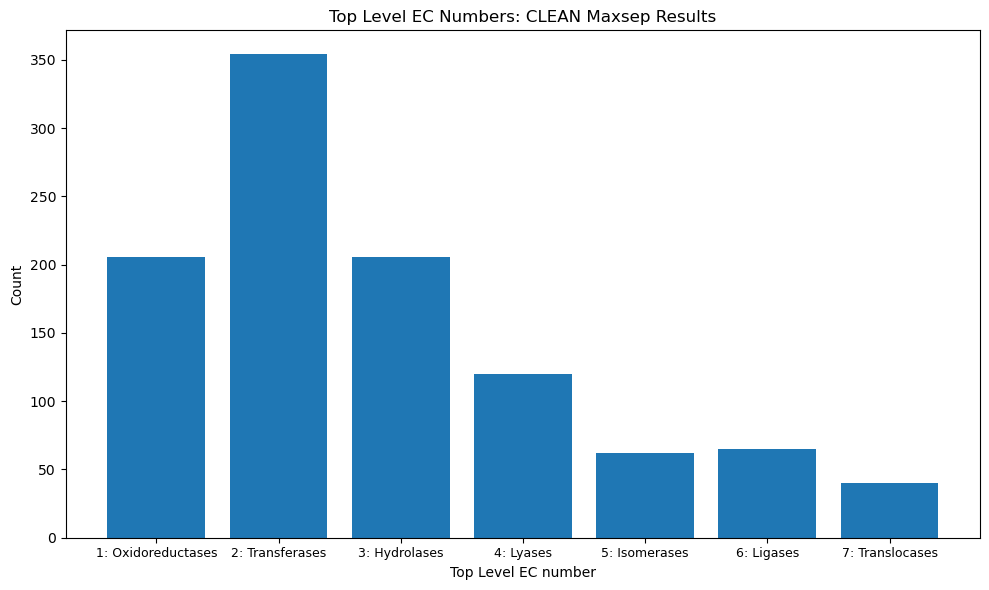

In [8]:
visualize_first_digits_distribution(set(clean_maxsep_ec_list), 'Top Level EC Numbers: CLEAN Maxsep Results')

In [9]:
# BioCyc dataset
biocyc = pd.read_csv('biocyc_updated.csv')
print("row and col numbers for biocyc dataframe:", biocyc.shape)
print("Number of non-NaN values in the 'BioCyc EC' column:", biocyc['BioCyc EC'].count())
print("Number of non-NaN values in the 'UniProt' column:", biocyc['UniProt'].count())

# these are all the unique EC numbers from the BioCyc data 
# some of these EC numbers do not have a UniProt id entry for that row
biocyc_ec_list = list_of_unique_ecs(biocyc, 'BioCyc EC')
print("unique number of ec numbers in BioCyc dataset:", len(biocyc_ec_list))

row and col numbers for biocyc dataframe: (728, 7)
Number of non-NaN values in the 'BioCyc EC' column: 691
Number of non-NaN values in the 'UniProt' column: 721
unique number of ec numbers in BioCyc dataset: 605


In [10]:
biocyc

,UniProt,Genes of a reaction from All instances of Reactions in Prochlorococcus marinus pastoris CCMP1986,Matches,Accession-1,Accession-2,Gene products (polypeptides and RNAs only),BioCyc EC
0,Q7V2E7,aarA,octadecanal + acyl-carrier protein + NAD(P)+ ...,PMM0533,TX50_RS02855,long-chain acyl-[acyl-carrier-protein] reductase,EC:1.2.1.80
1,Q7V2E6,accA,acetyl-CoA + a [carboxyl-carrier protein dimer...,PMM0534,TX50_RS02860,acetyl-CoA carboxylase carboxyltransferase sub...,EC:2.1.3.15
2,Q7TUH9,accB,ATP + acetyl-CoA + hydrogencarbonate -> ADP ...,PMM0027,TX50_RS00150,acetyl-CoA carboxylase biotin carboxyl carrier...,EC:6.4.1.2
3,Q7V3L5,accC,a [biotin carboxyl-carrier-protein dimer]-N6-b...,PMM0060,TX50_RS00320,acetyl-CoA carboxylase biotin carboxylase subunit,EC:6.3.4.14
4,Q7V1S1,accD,acetyl-CoA + a [carboxyl-carrier protein dimer...,PMM0784,TX50_RS04185,acetyl-CoA carboxylase carboxyltransferase sub...,EC:2.1.3.15
...,...,...,...,...,...,...,...
723,NaN,ycf12,RXN-15490 // oxygen[in] + 4 H+[in] + 4 e-[memb...,NaN,NaN,photosystem II reaction center protein Ycf12,"EC:1.1.3, EC:1.10.3.9"
724,Q7V0W4,ychF,ATP + H2O -> ADP + phosphate + H+,PMM1138,TX50_RS06135,redox-regulated ATPase YchF,EC:3.6.1.15
725,Q7V3G0,zds,beta-zeacarotene + an electron-transfer quinon...,PMM0115,TX50_RS00605,"9,9'-di-cis-zeta-carotene desaturase",EC:1.3.5.6
726,Q7V3E5,zntA,a metal cation[out] + ATP + H2O -> a metal c...,PMM0131,TX50_RS00690,P-type cation transporter,NaN


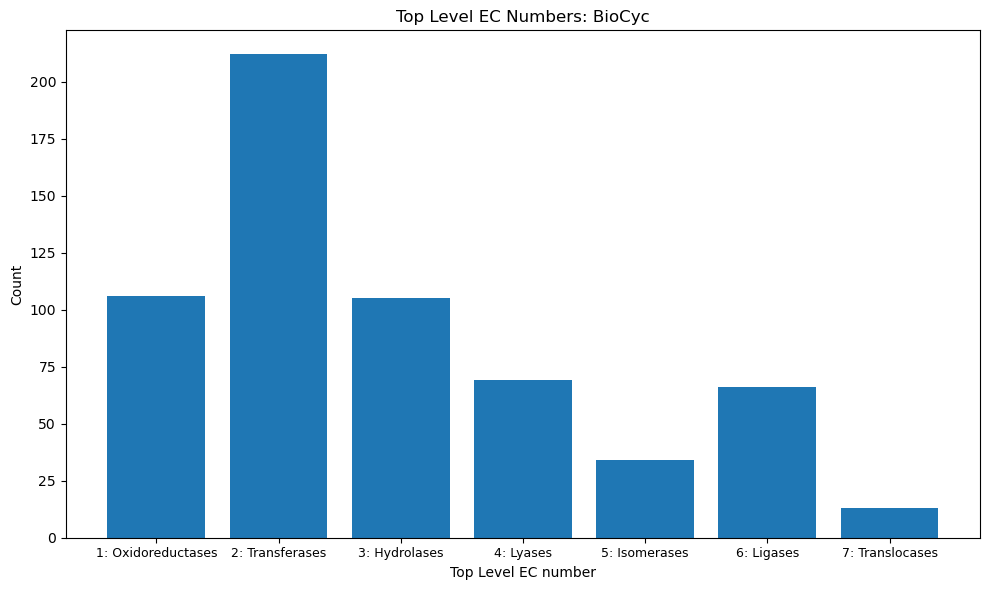

In [11]:
visualize_first_digits_distribution(set(biocyc_ec_list), 'Top Level EC Numbers: BioCyc')

### Combine the dataset visuals into one to look at all the unique EC numbers, by top level EC number

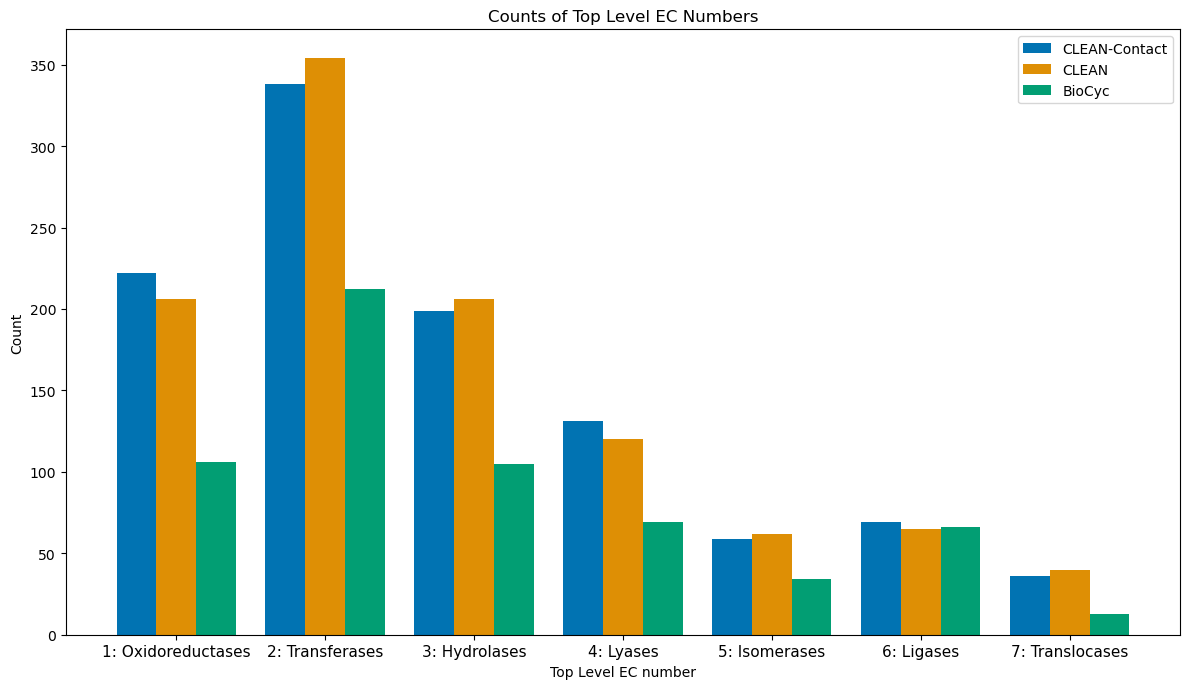

In [12]:
# these are the unique ec numbers found in each of the 3 datasets, representing the metabolic capabilities of the 
# organism according to each dataset
# this visual is the actual counts of ec numbers with the corresponding top level ec number per dataset 
# recall that these datasets started with different row numbers/uniprot ids from each other, so the next visual 
# with the percentages is also provided for clearer comparisons
all_sets = [set(cc_maxsep_ec_list), set(clean_maxsep_ec_list), set(biocyc_ec_list)]
custom_labels = ['CLEAN-Contact', 'CLEAN', 'BioCyc']
visualize_combined_distributions(all_sets, "Counts of Top Level EC Numbers", custom_labels)

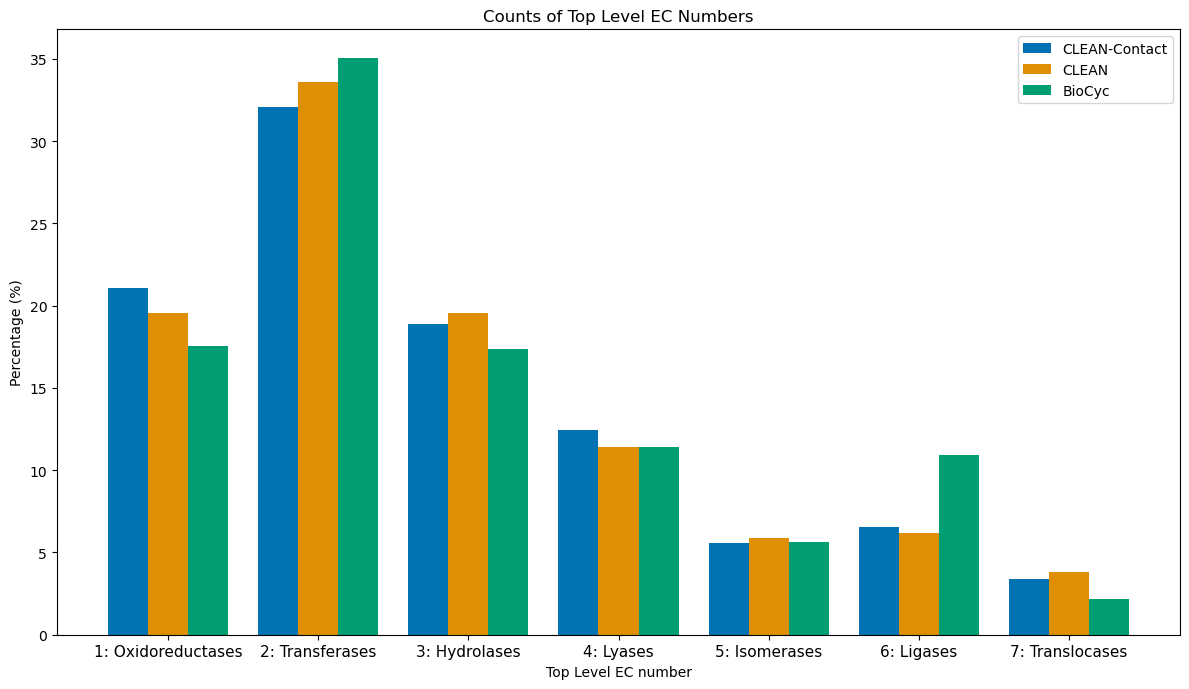

In [13]:
# each input set was the unique list of ec numbers in that dataset, and percent is calculated per set 
# example: the left-most blue bar for top level 1 means from the unique ec 
# numbers predicted by CLEAN-Contact, around 20% of all those unique ec numbers started with 1
all_sets = [set(cc_maxsep_ec_list), set(clean_maxsep_ec_list), set(biocyc_ec_list)]
custom_labels = ['CLEAN-Contact', 'CLEAN', 'BioCyc']
visualize_combined_distributions(all_sets, "Counts of Top Level EC Numbers", custom_labels, use_percent=True)
# without using a confidence score threshold, this looks like CLEAN-Contact provided proportionately more 
# oxidoreductases, lysases, and ligases than CLEAN

### Analyze unions and intersections of the 3 datasets

In [14]:
# calculate the subsets
only_cc_maxsep, only_clean_maxsep, only_biocyc, cc_maxsep_and_clean_maxsep, cc_maxsep_and_biocyc, clean_maxsep_and_biocyc, all_three = calculate_subsets(cc_maxsep_ec_list, clean_maxsep_ec_list, biocyc_ec_list)
print("only in cc:", len(only_cc_maxsep)) 
print("only in clean:", len(only_clean_maxsep)) 
print("only in biocyc:", len(only_biocyc)) 
print("in cc and clean:", len(cc_maxsep_and_clean_maxsep)) 
print("in cc and biocyc:", len(cc_maxsep_and_biocyc)) 
print("in clean and biocyc:", len(clean_maxsep_and_biocyc)) 
print("in all three:", len(all_three))

only in cc: 350
only in clean: 352
only in biocyc: 119
in cc and clean: 244
in cc and biocyc: 29
in clean and biocyc: 26
in all three: 431


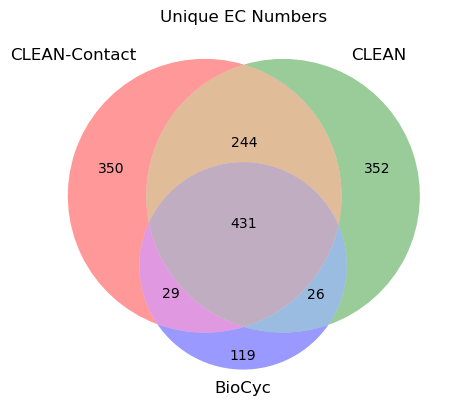

In [15]:
# venn diagram for all unique ec numbers in the three datasets
# note: at this point the datasets still have different UniProt ids and there hasn't been any filter for confidence scores
venn3([set(cc_maxsep_ec_list), set(clean_maxsep_ec_list), set(biocyc_ec_list)], ('CLEAN-Contact', 'CLEAN', 'BioCyc'))
plt.title('Unique EC Numbers')
plt.show()

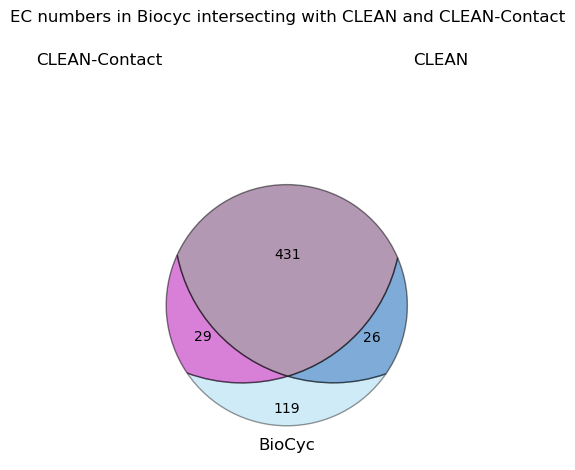

In [16]:
# look at just the purple BioCyc section of the above venn diagram
venn = venn3([set(cc_maxsep_ec_list), set(clean_maxsep_ec_list), set(biocyc_ec_list)], ('CLEAN-Contact', 'CLEAN', 'BioCyc'))

# make the patches for Set 2 and Set 3 clear
# comment this part out to keep the other circles in the visual
for id_ in ['100', '110', '111', '101', '010']:
    if venn.get_patch_by_id(id_):
        venn.get_patch_by_id(id_).set_alpha(0)

if venn.get_patch_by_id('001'):
    venn.get_patch_by_id('001').set_color('skyblue')
    venn.get_patch_by_id('001').set_edgecolor('black')

if venn.get_patch_by_id('011'):
    venn.get_patch_by_id('011').set_edgecolor('black')
    venn.get_patch_by_id('011').set_alpha(0.5)

if venn.get_patch_by_id('101'):
    venn.get_patch_by_id('101').set_edgecolor('black')
    venn.get_patch_by_id('101').set_alpha(0.5)
    
if venn.get_patch_by_id('111'):
    venn.get_patch_by_id('111').set_edgecolor('black')
    venn.get_patch_by_id('111').set_alpha(0.5)

for id_ in ['010', '110', '100']:
    if venn.get_label_by_id(id_):
        venn.get_label_by_id(id_).set_text('')
        
# remove the labels 
#venn.get_label_by_id('A').set_text('')
#venn.get_label_by_id('B').set_text('')

plt.title("EC numbers in Biocyc intersecting with CLEAN and CLEAN-Contact")
plt.tight_layout()
plt.show()


### Previously visualized the distributions of top level EC numbers in each of the 3 datasets, now visualize those distributions in each of the subsets from the venn diagram

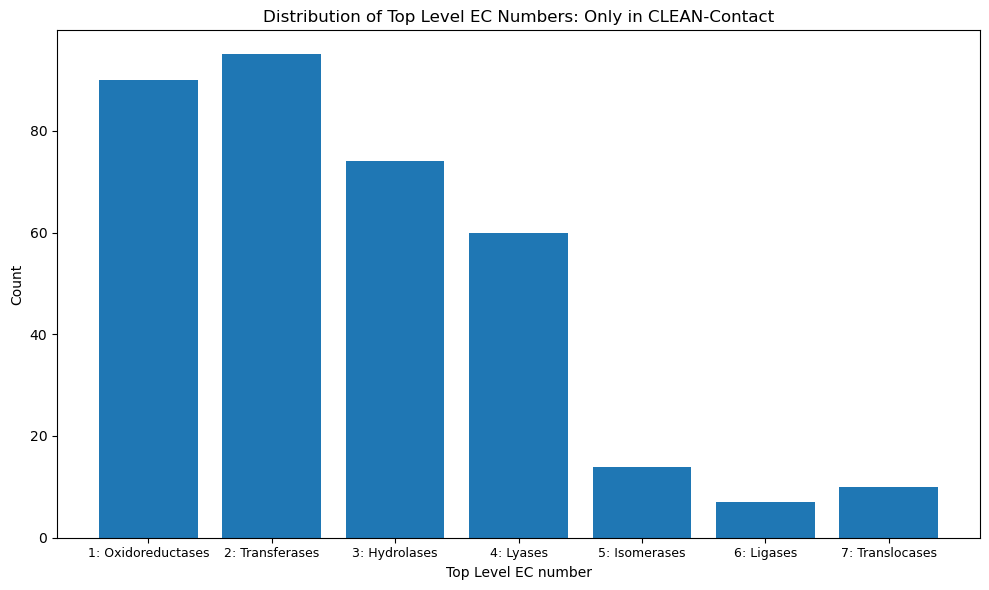

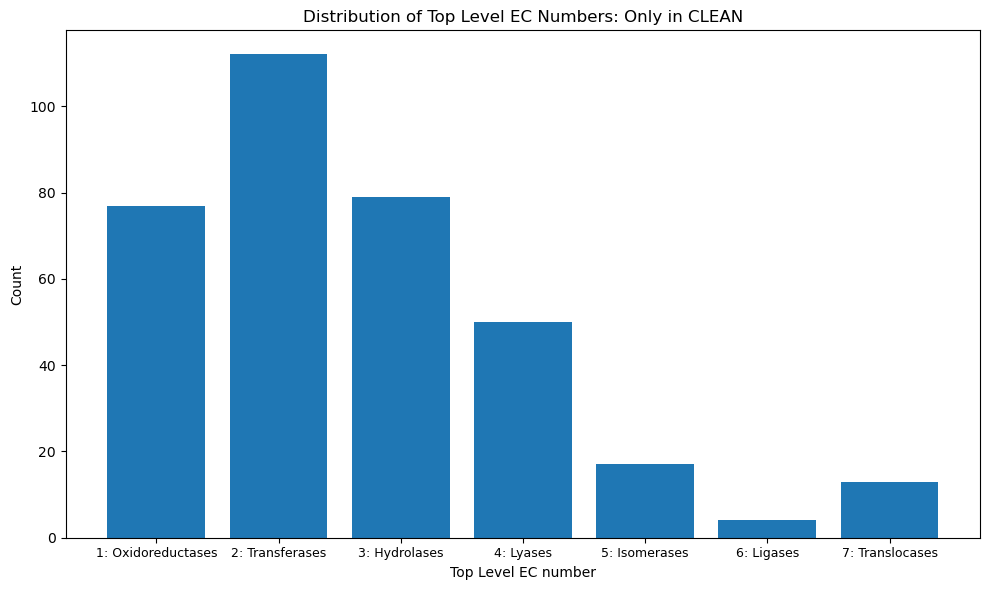

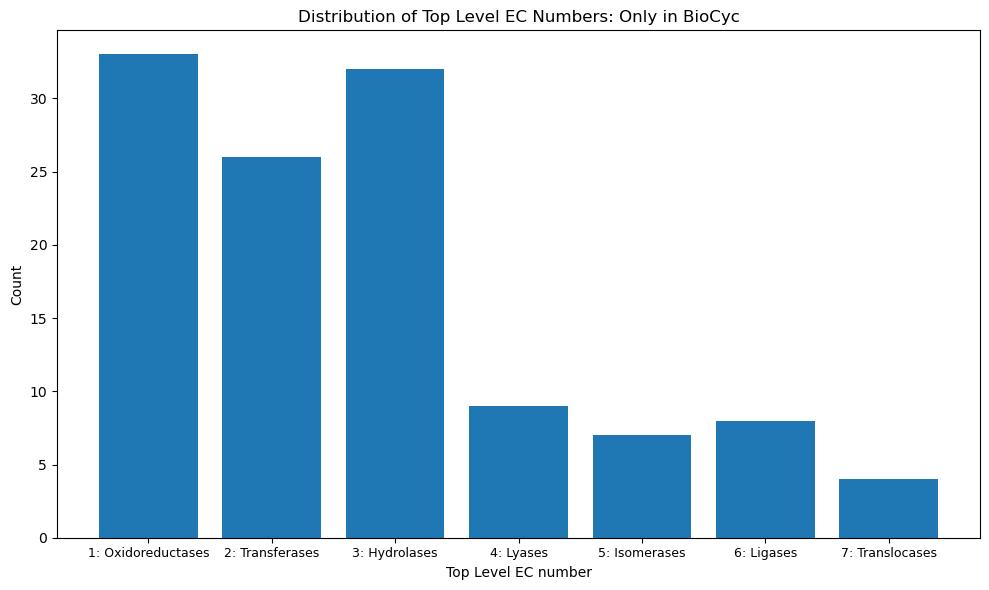

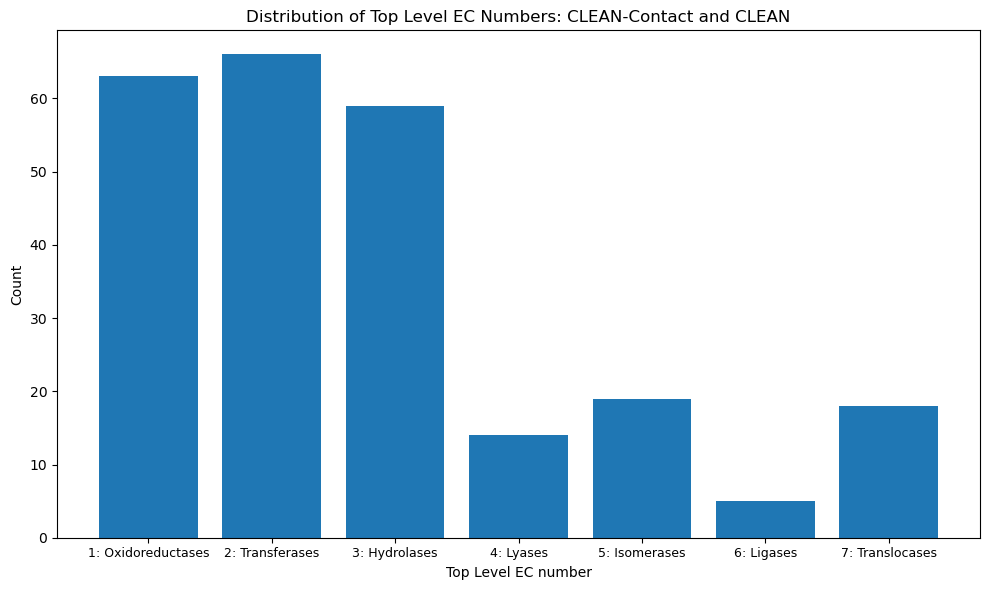

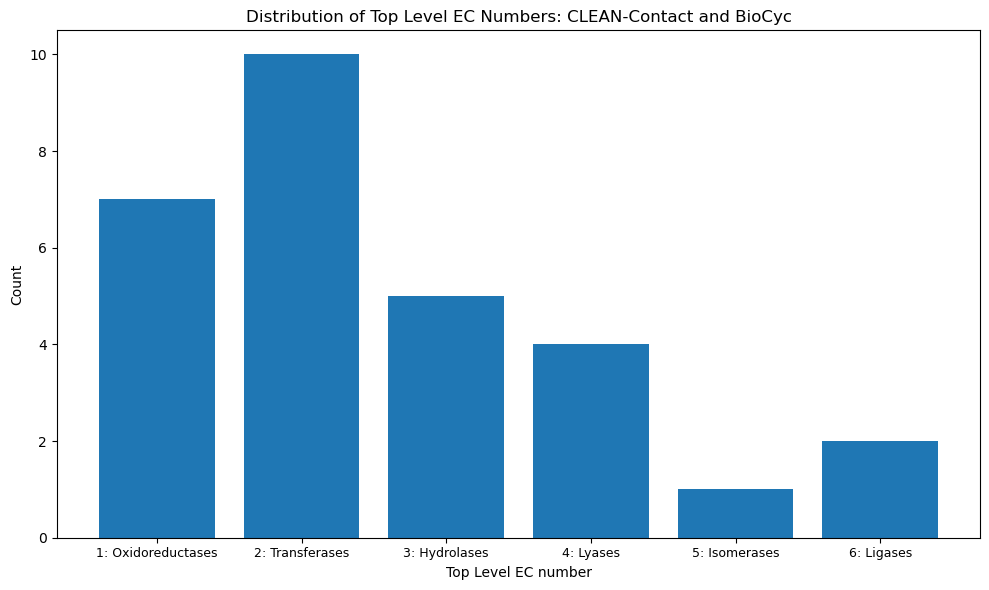

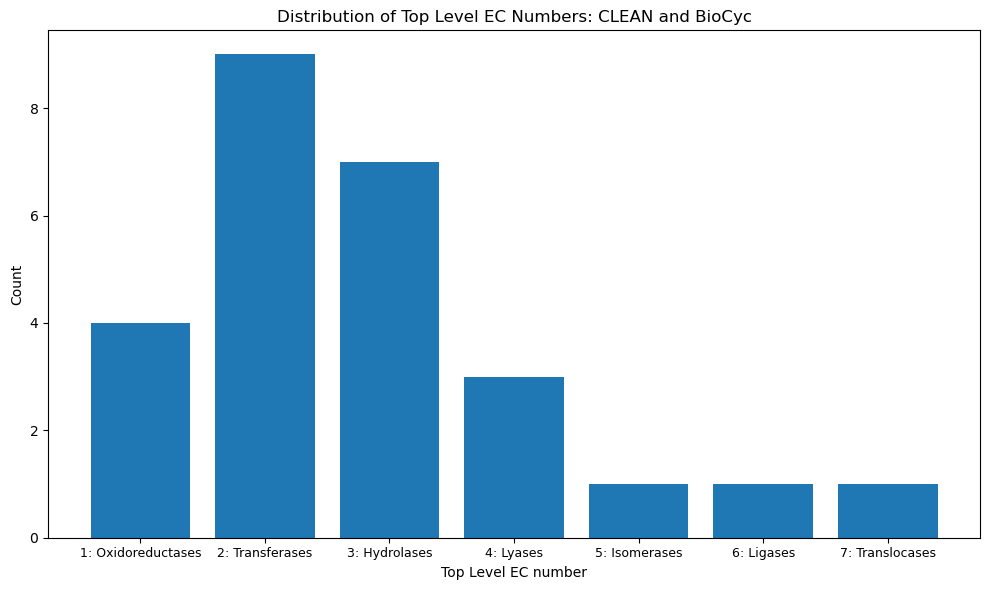

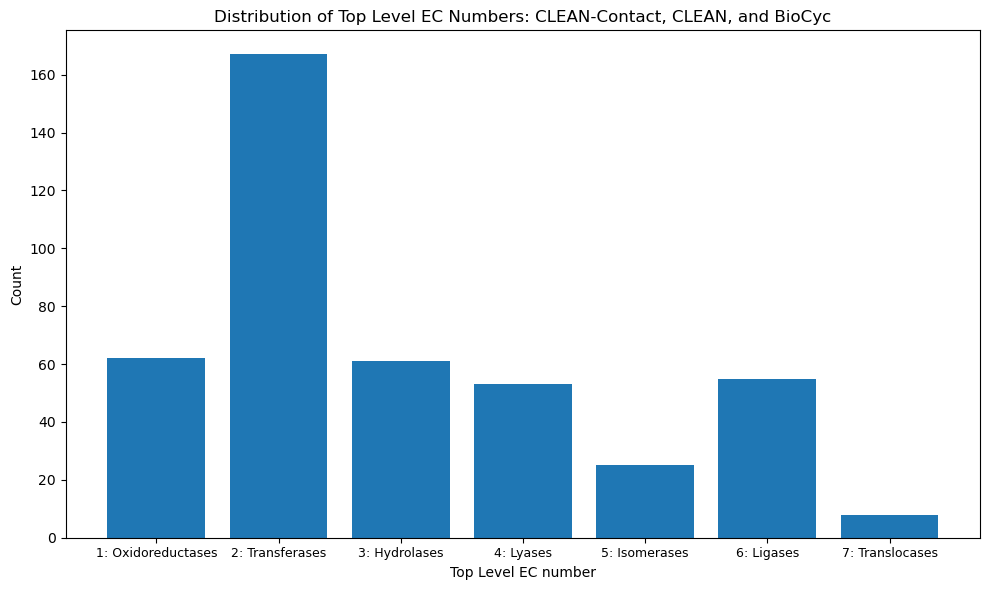

In [17]:
visualize_first_digits_distribution(only_cc_maxsep, 'Distribution of Top Level EC Numbers: Only in CLEAN-Contact')
# include True param for percentage not counts
#visualize_first_digits_distribution(only_cc_maxsep, 'Distribution of Top Level EC Numbers: Only in CLEAN-Contact', True)

visualize_first_digits_distribution(only_clean_maxsep, 'Distribution of Top Level EC Numbers: Only in CLEAN')
visualize_first_digits_distribution(only_biocyc, 'Distribution of Top Level EC Numbers: Only in BioCyc')
visualize_first_digits_distribution(cc_maxsep_and_clean_maxsep, 'Distribution of Top Level EC Numbers: CLEAN-Contact and CLEAN')
visualize_first_digits_distribution(cc_maxsep_and_biocyc, 'Distribution of Top Level EC Numbers: CLEAN-Contact and BioCyc')
visualize_first_digits_distribution(clean_maxsep_and_biocyc, 'Distribution of Top Level EC Numbers: CLEAN and BioCyc')
visualize_first_digits_distribution(all_three, 'Distribution of Top Level EC Numbers: CLEAN-Contact, CLEAN, and BioCyc')

### Analyze the confidence scores for CLEAN and CLEAN-Contact datasets

In [18]:
def separate_results(input_df, columns_to_split):
    # separate the rows with multiple results into multiple rows with one result per row
    df = input_df.copy()
    
    # split the results in each entry
    for column in columns_to_split:
        df[column] = df[column].str.split(',')
    
    # expand the DataFrame so that each list entry creates a new row
    df = df.explode(columns_to_split).reset_index(drop=True)
    
    # remove the whitespaces
    for column in columns_to_split:
        df[column] = df[column].str.strip()

    return df

In [19]:
# prep clean-contact results to analyze confidence scores
columns_to_split = ['CC maxsep EC', 'CC maxsep conf', 'CC maxsep conf SD', 'CC maxsep cluster dist']
cc_maxsep_expanded = separate_results(cc_maxsep, columns_to_split)
cc_maxsep_expanded['CC maxsep conf'] = pd.to_numeric(cc_maxsep_expanded['CC maxsep conf'])

In [20]:
# prep clean results to analyze confidence scores
clean_maxsep_cols = ['Clean maxsep EC', 'Clean maxsep conf']
clean_expanded = separate_results(clean_results, clean_maxsep_cols)
# pvalue cols not necessary to separate out here since they don't contain confidence scores
#clean_pvalue_cols = ['Clean pvalue EC', 'Clean pvalue cluster dist']
#clean_expanded = separate_results(clean_expanded, clean_pvalue_cols )
clean_expanded['Clean maxsep conf']= pd.to_numeric(clean_expanded['Clean maxsep conf'])

# confidence score threshold section

Recall that 1 UniProt id can have multiple EC number predictions and thus confidence scores. At this point, we already have dataframes of these expanded results, so each row only has 1 EC number and its 1 confidence score for the 1 UniProt id in that row. The below visuals include:

* all confidence scores for the 1939 UniProt ids in CLEAN-Contact results 
     * there are 977 unique values for the confidence scores
     * total 2327 rows of results when the data is separated so each UniProt id has one ec prediction/confidence score
        
* all confidence scores for the 1942 UniProt ids in CLEAN results
     * there are 837 unique values for the confidence scores
     * total 2341 rows of results when the data is separated so each UniProt id has one ec prediction/confidence score


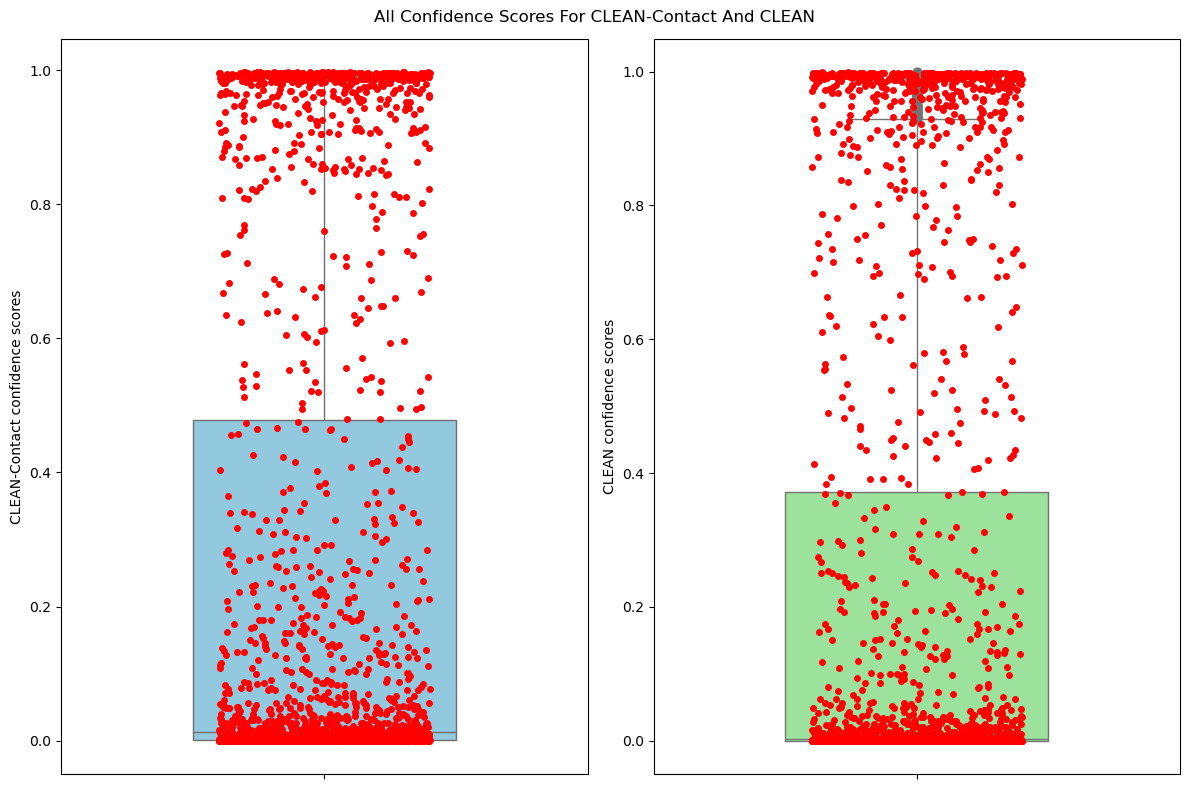

In [21]:
# comment out the 2 sns.stripplot() lines to view the boxplots without the red dots
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

sns.boxplot(data=cc_maxsep_expanded, y='CC maxsep conf', ax=axs[0], color='skyblue', width=.5)
sns.stripplot(data=cc_maxsep_expanded, y='CC maxsep conf', ax=axs[0], color='red', jitter=0.2)
axs[0].set_ylabel('CLEAN-Contact confidence scores')

sns.boxplot(data=clean_expanded, y='Clean maxsep conf', ax=axs[1], color='lightgreen', width=.5)
sns.stripplot(data=clean_expanded, y='Clean maxsep conf', ax=axs[1], color='red', jitter=0.2)
axs[1].set_ylabel('CLEAN confidence scores')

fig.suptitle('All Confidence Scores For CLEAN-Contact And CLEAN')

plt.tight_layout()
plt.show()

In [22]:
# look at the summary stats for the all confidence scores
print("CLEAN-Contact confidence scores summary")
print(cc_maxsep_expanded['CC maxsep conf'].describe(), "\n")

print("CLEAN confidence scores summary")
print(clean_expanded['Clean maxsep conf'].describe())

CLEAN-Contact confidence scores summary
count    2327.000000
mean        0.258521
std         0.392118
min         0.000000
25%         0.001000
50%         0.012500
75%         0.477800
max         0.996400
Name: CC maxsep conf, dtype: float64 

CLEAN confidence scores summary
count    2341.000000
mean        0.238374
std         0.389193
min         0.000000
25%         0.000200
50%         0.003300
75%         0.372000
max         0.998900
Name: Clean maxsep conf, dtype: float64


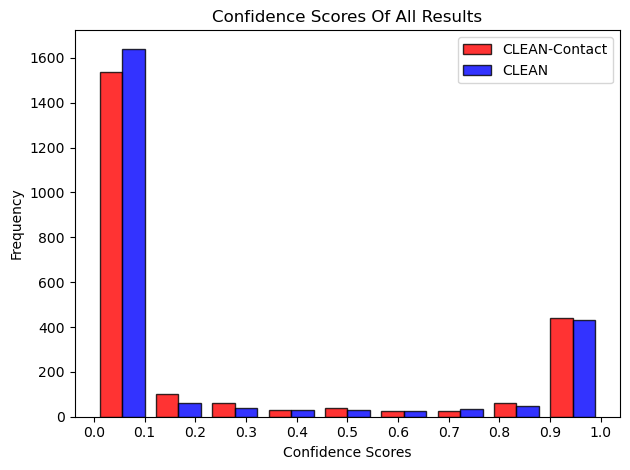

Chi-Square Statistic: 21.41985265723892
P-Value: 0.006111918217556259
The datasets have a statistically significant difference for the bins (p <= 0.05).


In [23]:
bins = np.linspace(0, 1, 10) 
plt.hist([cc_maxsep_expanded['CC maxsep conf'], clean_expanded['Clean maxsep conf']],
          bins=bins, color=['r', 'b'], alpha=0.8, label=['CLEAN-Contact', 'CLEAN'], edgecolor='black')

plt.xlabel('Confidence Scores')
plt.ylabel('Frequency')
plt.title("Confidence Scores Of All Results")

plt.legend(loc='upper right')
x_ticks = np.arange(0, 1.01, 0.1)
plt.xticks(x_ticks)
plt.tight_layout()

# uncomment savefig command to download plot as a .png
#plt.savefig('histogram_confidences_all.png', format='png', dpi=300, bbox_inches='tight')

# plt.show() has to be run after plt.savefig
plt.show()

# perform Chi-Square test even though I'm not 100% sure its helpful here? remove everything in this cell below if this
# test is not worth reporting
# calculate histogram counts 
cc_counts, _ = np.histogram(cc_maxsep_expanded['CC maxsep conf'], bins=bins)
clean_counts, _ = np.histogram(clean_expanded['Clean maxsep conf'], bins=bins)

# apply continuity correction by adding a small value to all counts if one bin has 0 counts in it
#cc_counts += .1
#clean_counts += .1

# use chi2_contingency not chisquare since there's not an expected distribution and observed; we're 
# comparing two different datasets to test if their distribution is the same
chi2_stat, p_val, dof, ex = chi2_contingency([cc_counts, clean_counts])

print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-Value: {p_val}")

# determine statistical significance
alpha = 0.05  
if p_val <= alpha:
    print("The datasets have a statistically significant difference for the bins (p <= 0.05).")
else:
    print("The datasets do not have a statistically significant difference for the bins (p > 0.05).")

### Find a confidence score cutoff and recreate some of the previous visuals

update the cutoff variable and run the cells below to get different visuals using that threshold

In [24]:
# cutoff must be between 0 and 1 (could incluse 0 or 1 if you really wanted to I guess)
cutoff = 0.1 # because just look at the above plot c'mon

# tried 0.4 but going through the rest of the visuals the results aren't anything special
#cutoff = 0.4 # because confidence scores below this threshold make up around 75% of both datasets? 

cc_filtered_conf = cc_maxsep_expanded[cc_maxsep_expanded['CC maxsep conf'] > cutoff]
print("CLEAN-Contact filtered dataframe shape:", cc_filtered_conf.shape)
clean_filtered_conf = clean_expanded[clean_expanded['Clean maxsep conf'] > cutoff]
print("CLEAN filtered dataframe shape:", clean_filtered_conf.shape)

CLEAN-Contact filtered dataframe shape: (805, 7)
CLEAN filtered dataframe shape: (707, 7)


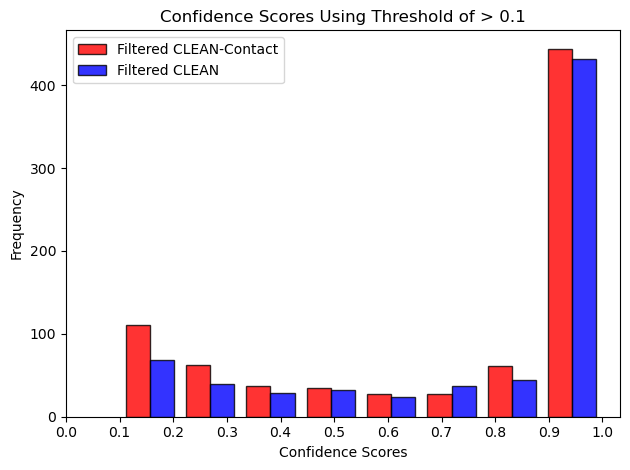

Chi-Square Statistic: 14.143645227947893
P-Value: 0.04868467553101896
The datasets have a statistically significant difference for the bins (p <= 0.05).


In [25]:
#bins = np.linspace(0.1, 1, 9) # keep this as bins for cutoff of 0.1
show_bins = 10-(cutoff*10)
bins = np.linspace(cutoff, 1, int(show_bins))
plt.hist([cc_filtered_conf['CC maxsep conf'], clean_filtered_conf['Clean maxsep conf']],
          bins=bins, color=['r', 'b'], alpha=0.8, label=['Filtered CLEAN-Contact', 'Filtered CLEAN'], edgecolor='black')

plt.xlabel('Confidence Scores')
plt.ylabel('Frequency')
plt.title(f'Confidence Scores Using Threshold of > {cutoff}')

plt.legend(loc='upper left')
x_ticks = np.arange(0, 1.01, 0.1)
plt.xticks(x_ticks)
plt.tight_layout()
plt.show()

# calculate histogram counts 
cc_counts, _ = np.histogram(cc_filtered_conf['CC maxsep conf'], bins=bins)
clean_counts, _ = np.histogram(clean_filtered_conf['Clean maxsep conf'], bins=bins)

# apply continuity correction by adding a small value to all counts if one bin has 0 counts in it
#cc_counts += .1
#clean_counts += .1

# perform Chi-Square test even though I'm not 100% sure its helpful here?
# use chi2_contingency not chisquare since there's not an expected distribution and observed; we're 
# comparing two different datasets to test if their distribution is the same
chi2_stat, p_val, dof, ex = chi2_contingency([cc_counts, clean_counts])

print(f"Chi-Square Statistic: {chi2_stat}")
print(f"P-Value: {p_val}")

# determine statistical significance
alpha = 0.05  
if p_val <= alpha:
    print("The datasets have a statistically significant difference for the bins (p <= 0.05).")
else:
    print("The datasets do not have a statistically significant difference for the bins (p > 0.05).")

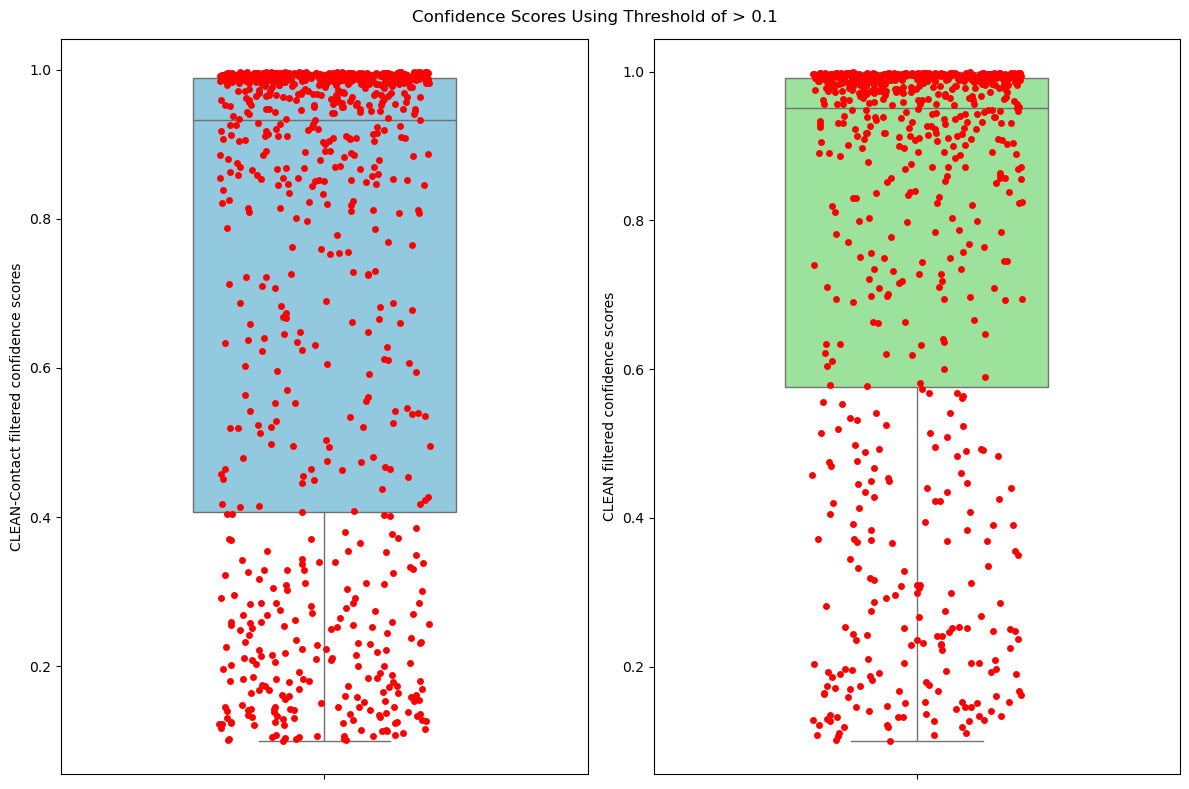

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))

sns.boxplot(data=cc_filtered_conf, y='CC maxsep conf', ax=axs[0], color='skyblue', width=.5)
sns.stripplot(data=cc_filtered_conf, y='CC maxsep conf', ax=axs[0], color='red', jitter=0.2)
axs[0].set_ylabel('CLEAN-Contact filtered confidence scores')

sns.boxplot(data=clean_filtered_conf, y='Clean maxsep conf', ax=axs[1], color='lightgreen', width=.5)
sns.stripplot(data=clean_filtered_conf, y='Clean maxsep conf', ax=axs[1], color='red', jitter=0.2)
axs[1].set_ylabel('CLEAN filtered confidence scores')

fig.suptitle(f'Confidence Scores Using Threshold of > {cutoff}')

plt.tight_layout()
plt.show()

In [27]:
print("Filtered CLEAN-Contact confidence scores summary")
print(cc_filtered_conf['CC maxsep conf'].describe(), "\n")

print("Filtered CLEAN confidence scores summary")
print(clean_filtered_conf['Clean maxsep conf'].describe())

Filtered CLEAN-Contact confidence scores summary
count    805.000000
mean       0.727505
std        0.327870
min        0.100100
25%        0.407100
50%        0.932900
75%        0.989200
max        0.996400
Name: CC maxsep conf, dtype: float64 

Filtered CLEAN confidence scores summary
count    707.000000
mean       0.774476
std        0.298685
min        0.100300
25%        0.575400
50%        0.950600
75%        0.991500
max        0.998900
Name: Clean maxsep conf, dtype: float64


In [28]:
cc_ec_list = list_of_unique_ecs(cc_filtered_conf, 'CC maxsep EC')
print("unique number of ec numbers in the filtered CLEAN-Contact dataset:", len(cc_ec_list)) 
clean_ec_list = list_of_unique_ecs(clean_filtered_conf, 'Clean maxsep EC')
print("unique number of ec numbers in the filtered CLEAN dataset:", len(clean_ec_list)) 

unique number of ec numbers in the filtered CLEAN-Contact dataset: 589
unique number of ec numbers in the filtered CLEAN dataset: 559


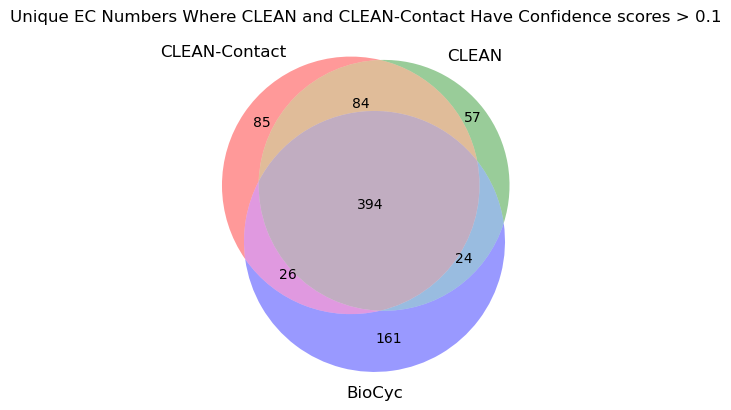

In [29]:
# new venn diagram for all unique ec numbers in the three datasets with cc and clean filtered by confidence
# biocyc numbers haven't changed: 728 rows in the dataframe, 691 rows with an EC number (non-NaN), 605 unique ec numbers
venn3([set(cc_ec_list), set(clean_ec_list), set(biocyc_ec_list)], ('CLEAN-Contact', 'CLEAN', 'BioCyc'))
plt.title(f'Unique EC Numbers Where CLEAN and CLEAN-Contact Have Confidence scores > {cutoff}') 
plt.show()

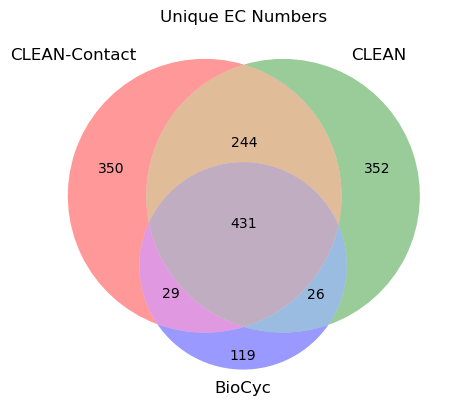

In [30]:
# compare to previous
venn3([set(cc_maxsep_ec_list), set(clean_maxsep_ec_list), set(biocyc_ec_list)], ('CLEAN-Contact', 'CLEAN', 'BioCyc'))
plt.title('Unique EC Numbers')
plt.show()

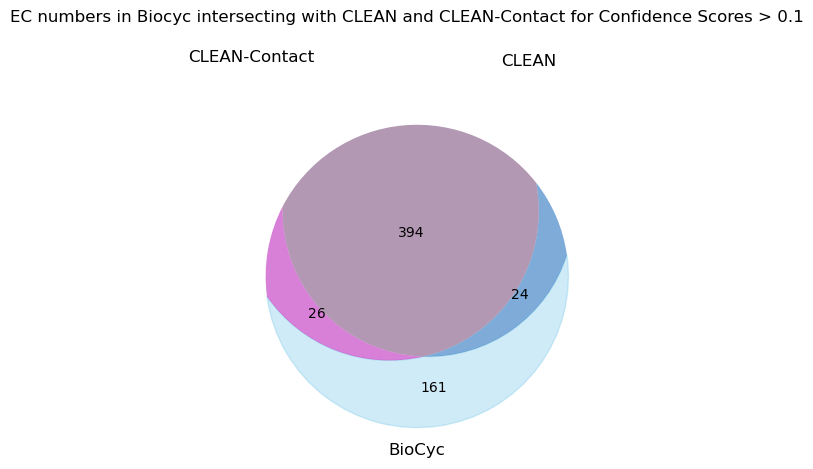

In [31]:
# look at just the purple BioCyc section 
venn = venn3([set(cc_ec_list), set(clean_ec_list), set(biocyc_ec_list)], ('CLEAN-Contact', 'CLEAN', 'BioCyc'))

# Make the patches for Set 2 and Set 3 clear
# comment this part out to keep the other circles
for id_ in ['100', '110', '111', '101', '010']:
    if venn.get_patch_by_id(id_):
        venn.get_patch_by_id(id_).set_alpha(0)

if venn.get_patch_by_id('001'):
    venn.get_patch_by_id('001').set_color('skyblue')
    #venn.get_patch_by_id('001').set_edgecolor('black')

if venn.get_patch_by_id('011'):
    #venn.get_patch_by_id('011').set_edgecolor('black')
    venn.get_patch_by_id('011').set_alpha(0.5)

if venn.get_patch_by_id('101'):
    #venn.get_patch_by_id('101').set_edgecolor('black')
    venn.get_patch_by_id('101').set_alpha(0.5)
    
if venn.get_patch_by_id('111'):
    #venn.get_patch_by_id('111').set_edgecolor('black')
    venn.get_patch_by_id('111').set_alpha(0.5)

for id_ in ['010', '110', '100']:
    if venn.get_label_by_id(id_):
        venn.get_label_by_id(id_).set_text('')
        
# Remove the labels 
#venn.get_label_by_id('A').set_text('')
#venn.get_label_by_id('B').set_text('')

# Add a title
plt.title(f"EC numbers in Biocyc intersecting with CLEAN and CLEAN-Contact for Confidence Scores > {cutoff}")

# Show the plot
plt.tight_layout()
plt.show()

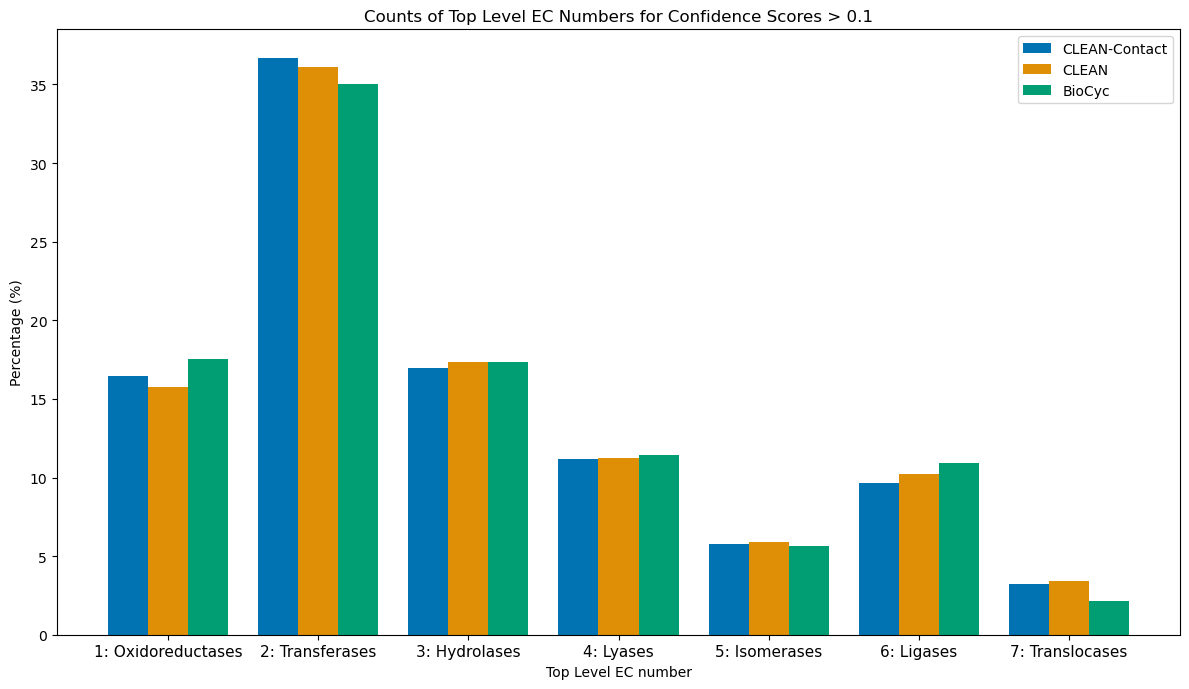

In [32]:
# each input set was unique list of ec numbers in that dataset, and percent is calculated per set 
all_sets = [set(cc_ec_list), set(clean_ec_list), set(biocyc_ec_list)]
custom_labels = ['CLEAN-Contact', 'CLEAN', 'BioCyc']
visualize_combined_distributions(all_sets, f"Counts of Top Level EC Numbers for Confidence Scores > {cutoff}", 
                                 custom_labels, use_percent=True) 

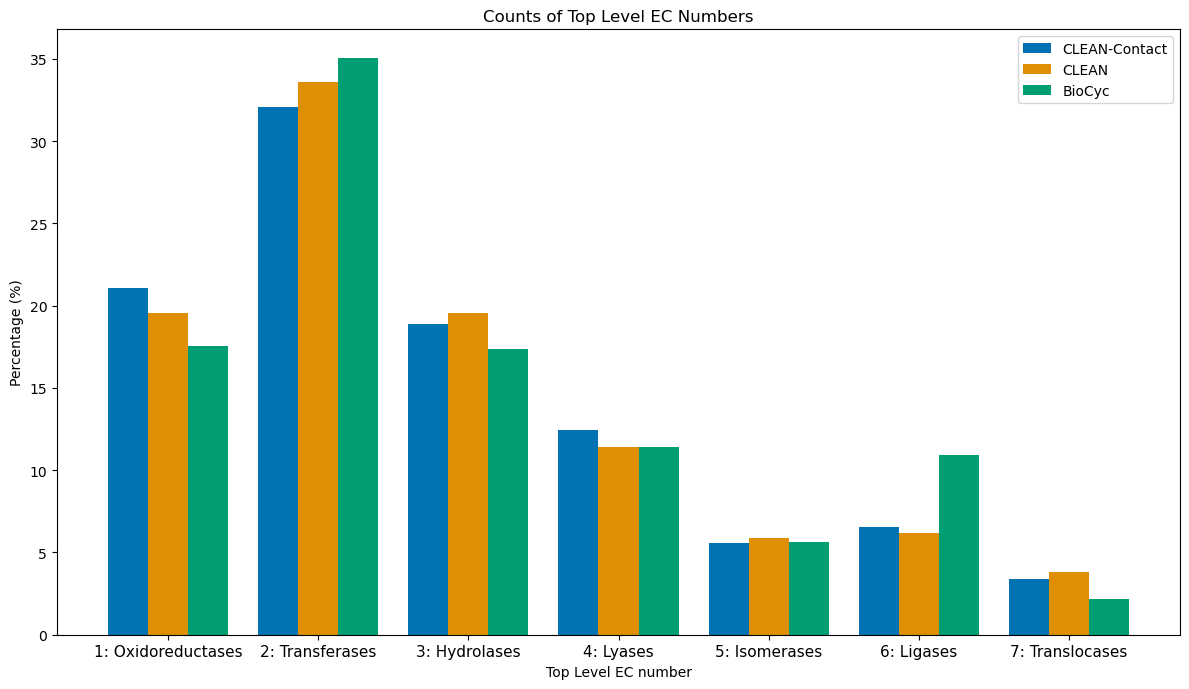

In [33]:
# compare to previous
# each input set was unique list of ec numbers in that dataset, and percent is calculated per set (and per top level) 
# so the blue bar for top level 1 means from the unique ec 
# numbers predicted by cc, around 20% of all those unique ec numbers started with 1
all_sets = [set(cc_maxsep_ec_list), set(clean_maxsep_ec_list), set(biocyc_ec_list)]
custom_labels = ['CLEAN-Contact', 'CLEAN', 'BioCyc']
visualize_combined_distributions(all_sets, "Counts of Top Level EC Numbers", custom_labels, use_percent=True)
# cc provided proportionately more oxidoreductases, lysases, and ligases than clean